**Задача:** предобработать полученный excel файл с данными по загрязняющим веществам и отобрать выборку для дальнейшего анализа

In [55]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

import itertools

import os
from pathlib import Path

#get my written functions
from userfuncs import prepare_dataframe, find_borders_nan_intervals, count_frequency, count_missing

In [56]:
#sns.set(style='darkgrid')
from matplotlib import style
style.use('fivethirtyeight')

In [57]:
path_to_data = Path('../../data')
df = pd.read_excel(path_to_data / 'prioksk_ter_2020.xlsx')
df.head(2)

,YY,MM,DD,ST,PL,MD,DU,TSP,Q_TSP,SO2,...,Q_CD,NO2,Q_NO2,NO,Q_NO,Примечание,с аэрозол,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,83.0,12.0,6.0,4.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,мг/г,NaN,NaN,NaN
1,83.0,12.0,7.0,4.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Preparation of data**

In [58]:
drop_cols = ['ST', 'PL', 'MD', 'DU', 'Примечание', 'с  аэрозол', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27']

In [59]:
print(f"Shape before preparation: {df.shape}\n")
df, wrong_dates = prepare_dataframe(df, drop_cols, return_wrong_dates=True)
print(f"\nShape after preparation: {df.shape}")

Shape before preparation: (12128, 28)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 
Got wrong date YY MM DD, it'll be dropped
  



Shape after preparation: (12068, 16)


Check wrong dates

In [60]:
for v in wrong_dates:
    print(f"{v[0]}/{v[1]}/{v[2]}")

1998/9/31


Check if all dates are unique

In [61]:
for val, freq in count_frequency(df.index.tolist()):
    if freq > 1:
        print(val, freq)

1994-04-02 00:00:00 2
1995-09-27 00:00:00 2
1995-11-28 00:00:00 2
1998-09-20 00:00:00 2


Since there're nonunique dates, they should be preprocessed
<br>
I'll keep only the first appearance

In [62]:
df = df.loc[~df.index.duplicated(keep='first')]

In [63]:
#Columns that can be explored not starting with "Q_"
use_cols = [col for col in df.columns if not col.startswith('Q_')]
df = df[use_cols]

**Get some information about data**

In [64]:
xx = count_missing(df, is_print=True, return_df=True)

                       Some information about data
----------------------------------------------------------------------
Element | Count NaN | Count no-NaN | First valid date| Last valid date
----------------------------------------------------------------------
TSP        4695           7099        1985-01-03        2017-09-30
SO2         943          10377        1986-06-01        2017-09-30
SO4        4617           7177        1985-01-03        2017-09-30
HG         6694           4359        1987-03-01        2017-09-28
PB         6581           5481        1983-12-06        2017-09-28
CD         6637           5425        1983-12-06        2017-09-28
NO2        2752           4539        1997-08-02        2017-09-30
NO        12064              0              None              None

P.S. valid date means that before or after this date there're only missing values.
Of course nonvalid dates are omitted


In [65]:
df = df.drop(['NO'], axis=1)

**Задача:** набрать наиболее непрерывные данные для дальнейшего корректного их анализа

Отличительной особенностью является тот факт, что с 24 марта 1994 года в Приокско-Террасном биосферном заповеднике было принято решение изменить схему сбора проб почвы на наличие свинца и кадмия. Она перешла с ежедневной на раз в 2-3 дня.

Исходя из полученной информации, конечную дату выставлю в 1994-03-24
<br>
Начальной же возьму 1987-03-01 для учета наибольшего числа рядов

In [82]:
def plot_series(df, start_date=None, end_date=None, is_fill_space=False):
    lw = 2
    start_ix = list(df.index).index(start_date) if start_date else 0
    end_ix = list(df.index).index(end_date) if end_date else -2
    for col in df.columns:
        print(col)
        #get ts for specific column
        ts = df[[col]].iloc[start_ix: end_ix + 1,:].copy()
        #get valid indexes of 1-st and last appearance for the column
        fir_ix = ts[col].first_valid_index()
        last_ix = ts[col].last_valid_index()
        if fir_ix is None or last_ix is None:
            print(f"For {col} first valid date is {df[[col]].first_valid_index()}")
            print(f"For {col} last valid date is {df[[col]].last_valid_index()}")
            continue
        fir_ix = ts.index.get_loc(fir_ix)
        last_ix = ts.index.get_loc(last_ix)

        ts = ts.iloc[fir_ix:last_ix+1, :]
        #plot
        plt.figure(figsize=(20,10))
        #plot true given elements
        plt.plot(ts.index, ts[col], label=f"{col}", lw=lw)
        if is_fill_space:
            plt.fill_between(ts.index, ts[col])
        #plot epsilon around zero where missing values are (nan)
        ts['nan'] = np.where(ts[col].isna(), 1e-5, np.nan)
        tmp = ts['nan'].unique()
        if not (len(tmp) == 1 and np.isnan(tmp[0])):
            plt.scatter(ts.index, ts['nan'], color='r', label=f" missed {col}",  marker='|', s=5)
        plt.legend(loc='best', fontsize='x-large')
        plt.ylabel('Quantity', fontsize=16)
        if pd.api.types.is_datetime64_any_dtype(df.index.dtype):
            plt.xlabel('Year', fontsize=16)
        else:
            plt.xlabel('Observation', fontsize=16)
        plt.tick_params(labelsize=17)



        plt.show()

TSP


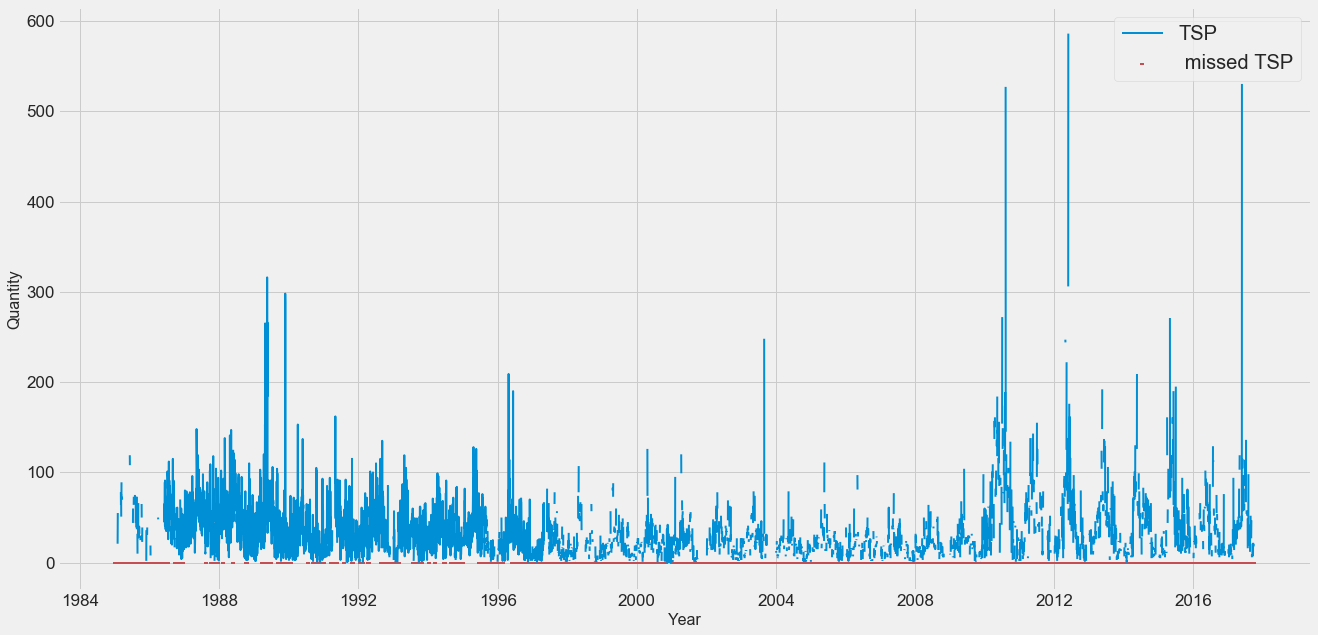

SO2


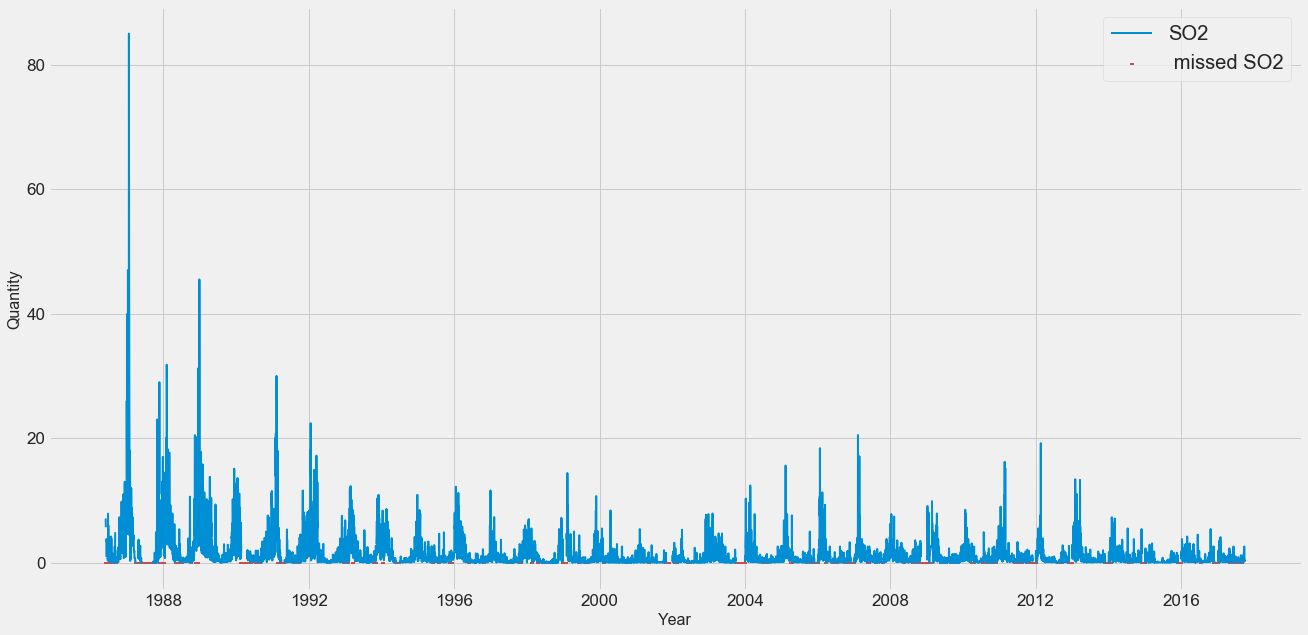

SO4


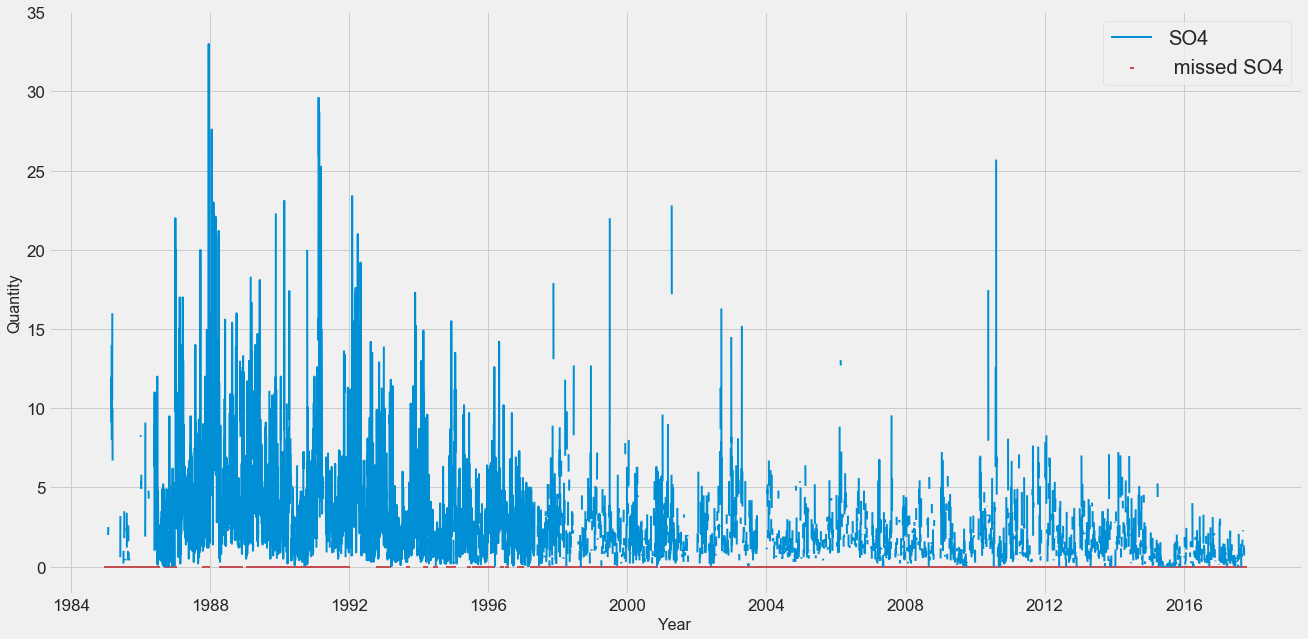

HG


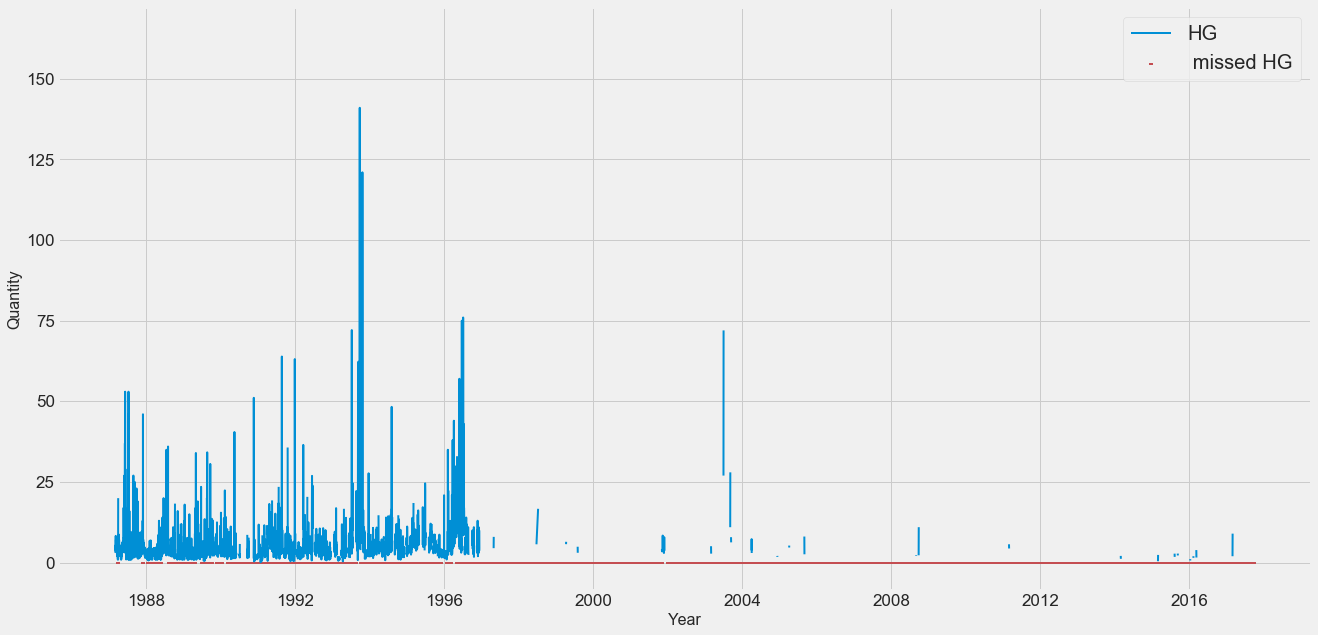

PB


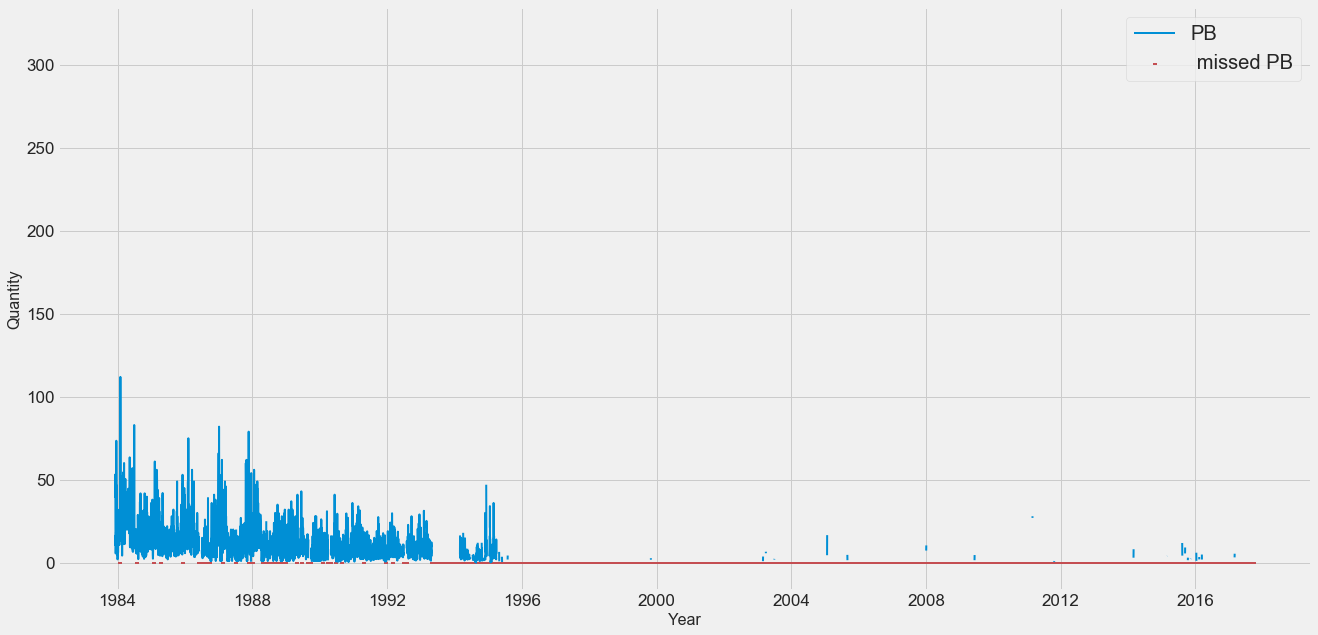

CD


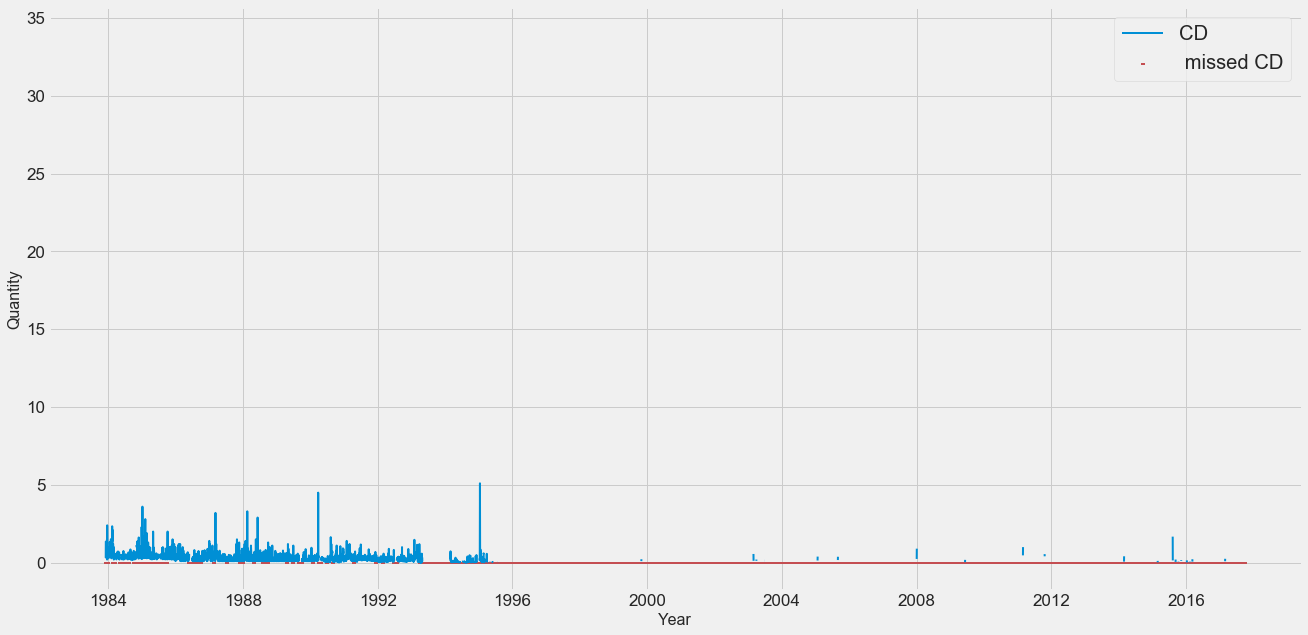

NO2


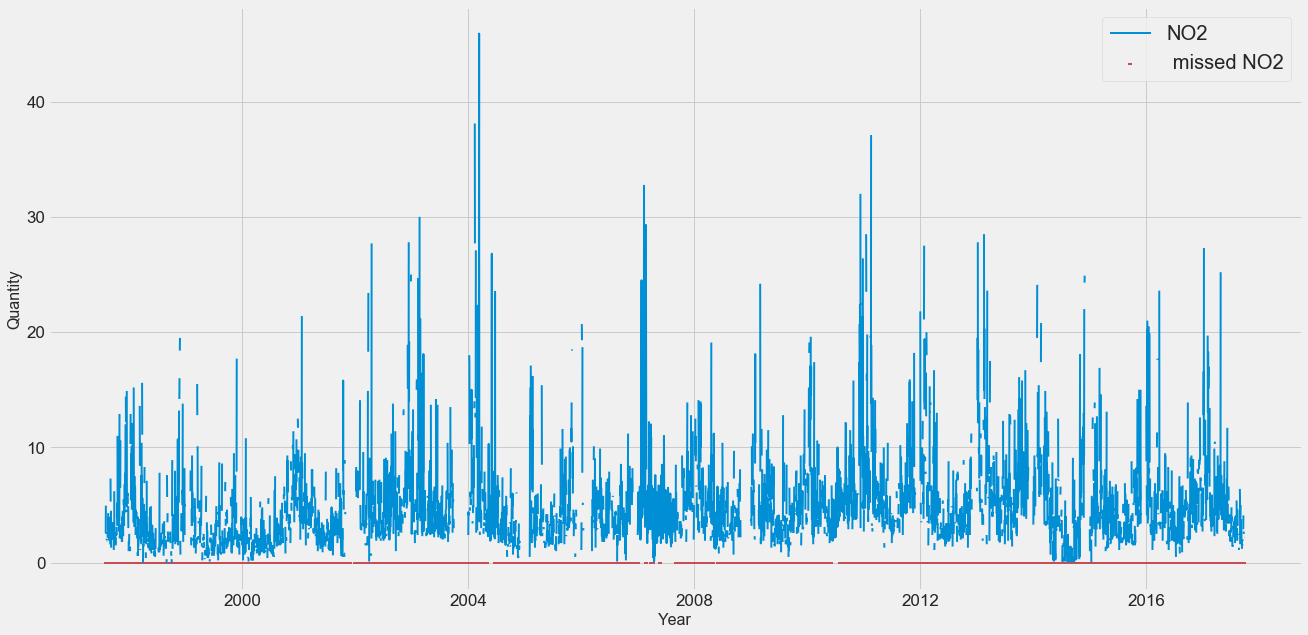

In [83]:
plot_series(df)

**NO2** не подходит, так как замеры начали делать сильно позже остальных и содержит очень много пропусков
<br>
**HG** не подходит из-за большого кол-во пропусков
**SO4** на мой взгляд неоднозначно, можно и убрать

Даты возьму: конец 1987 по начало 1993 (подобрано с учетом построения графиков, чтобы выделить лучшие участки)

						TRAIN
TSP


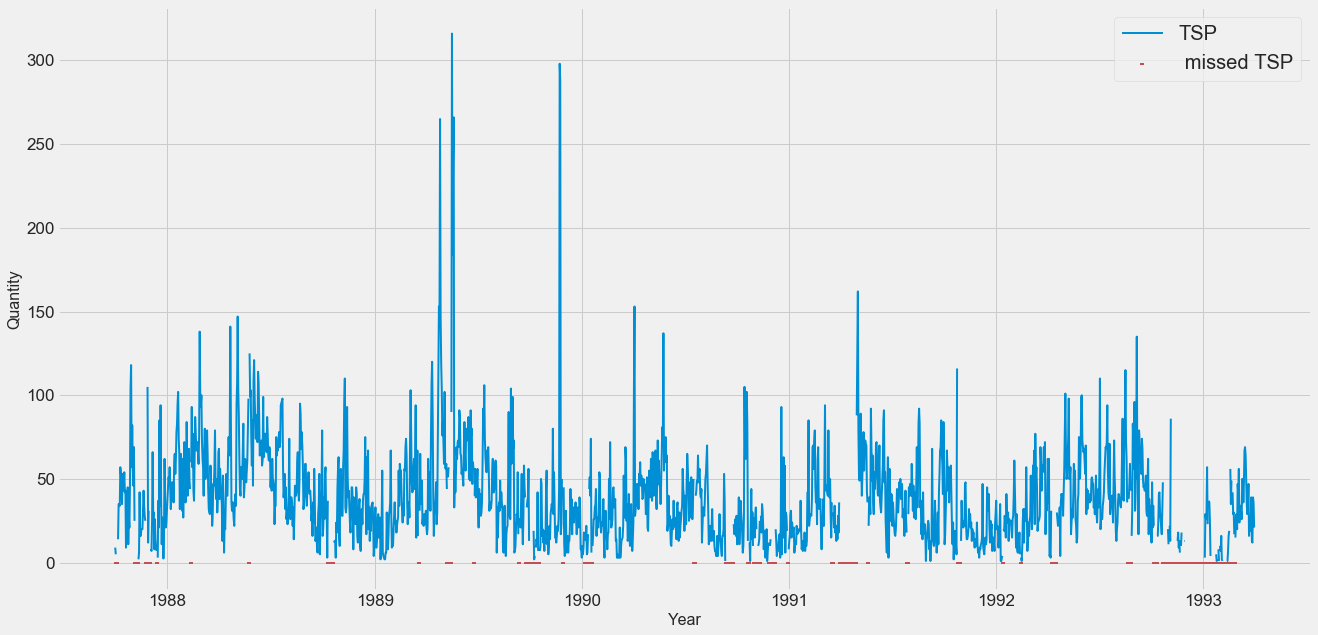

SO2


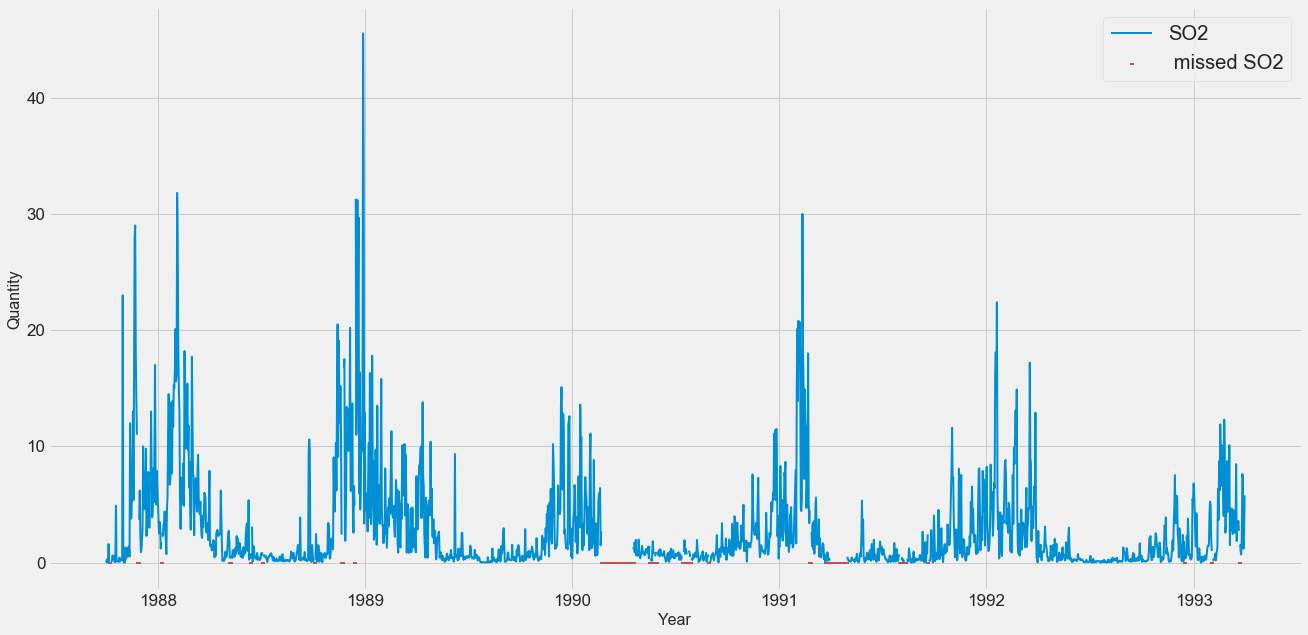

SO4


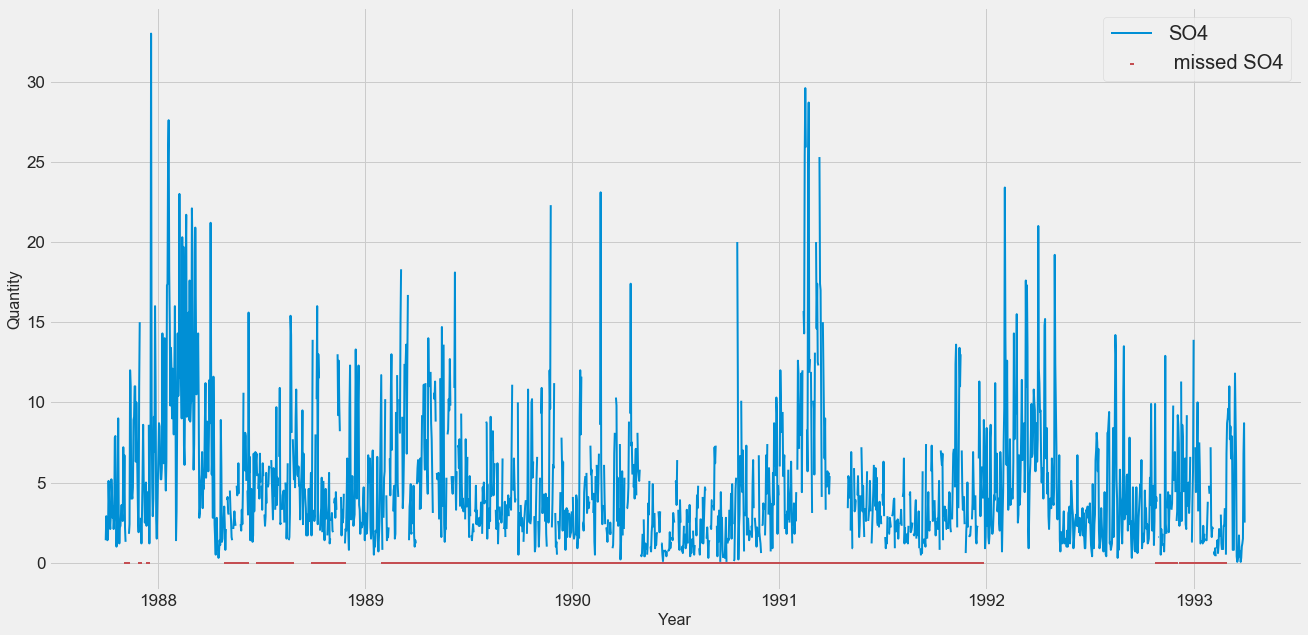

PB


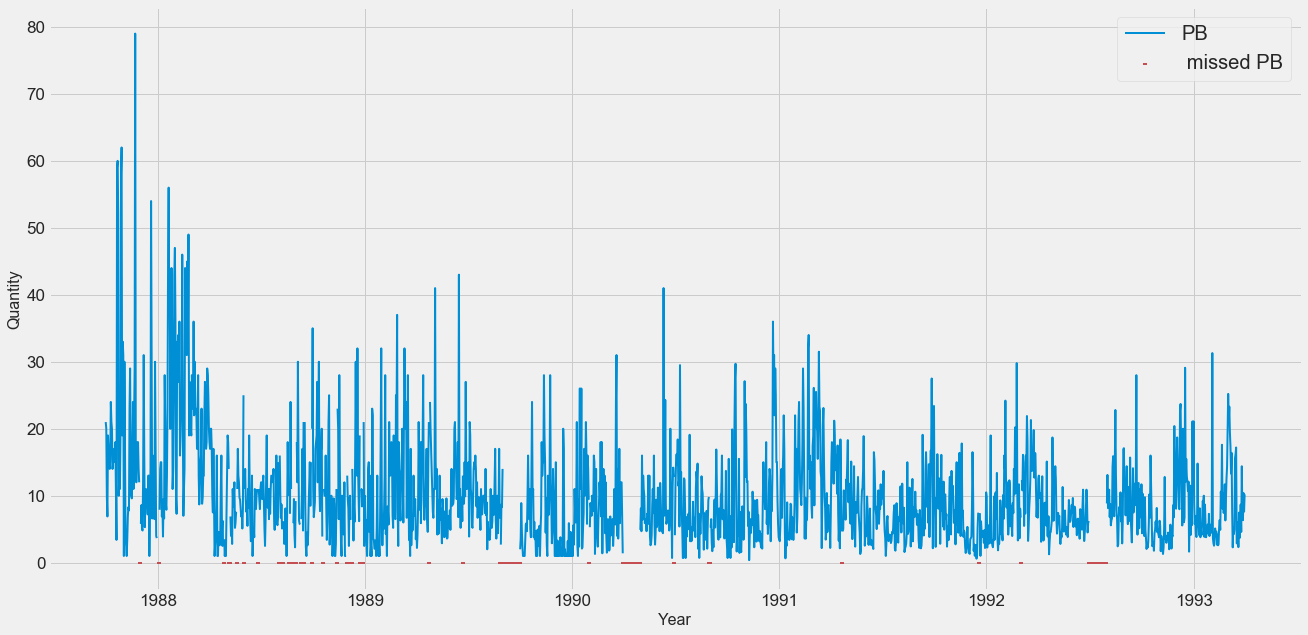

CD


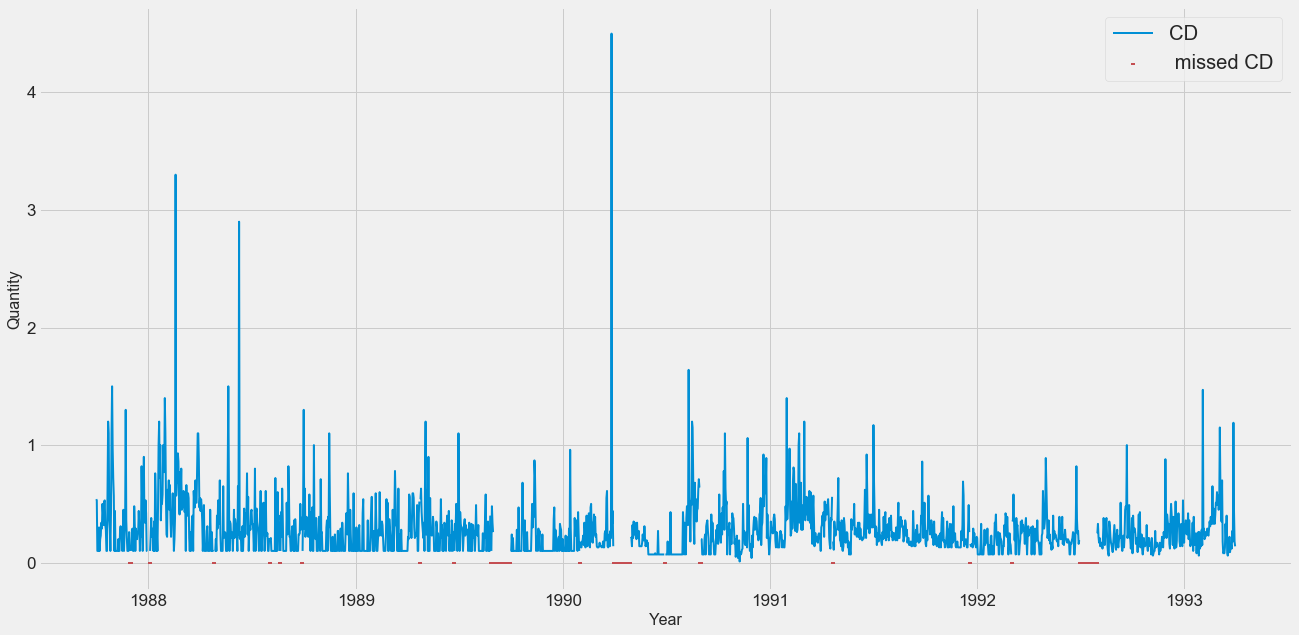

				TEST
TSP


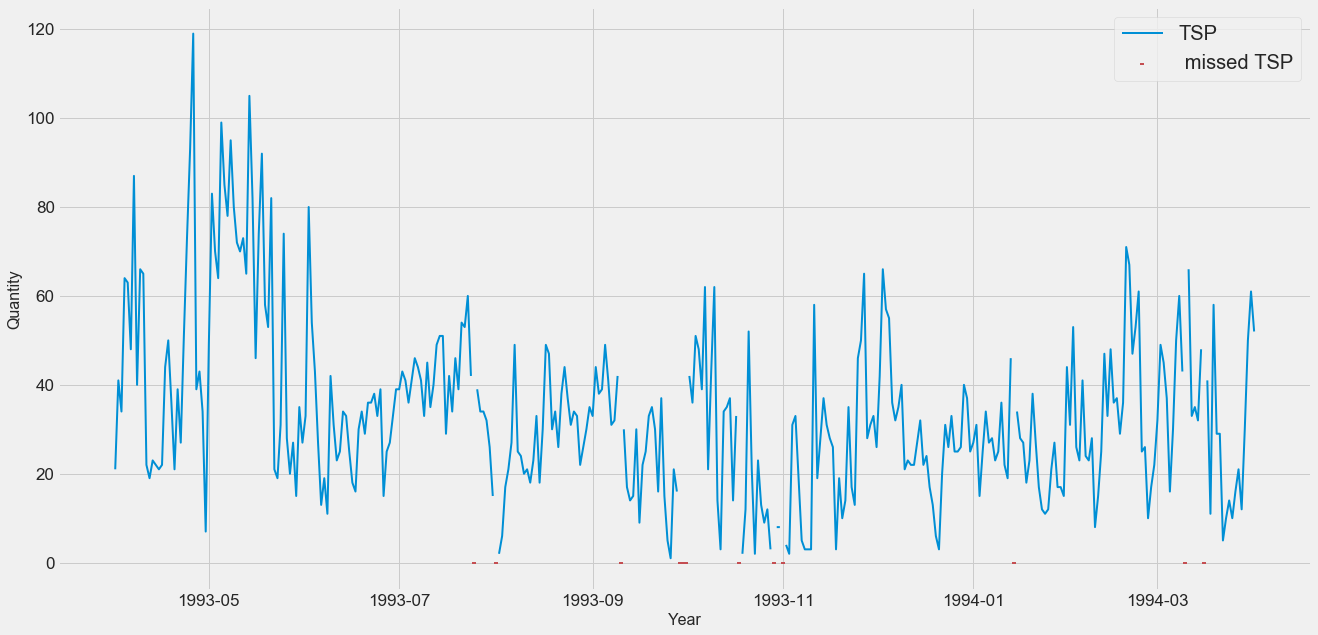

SO2


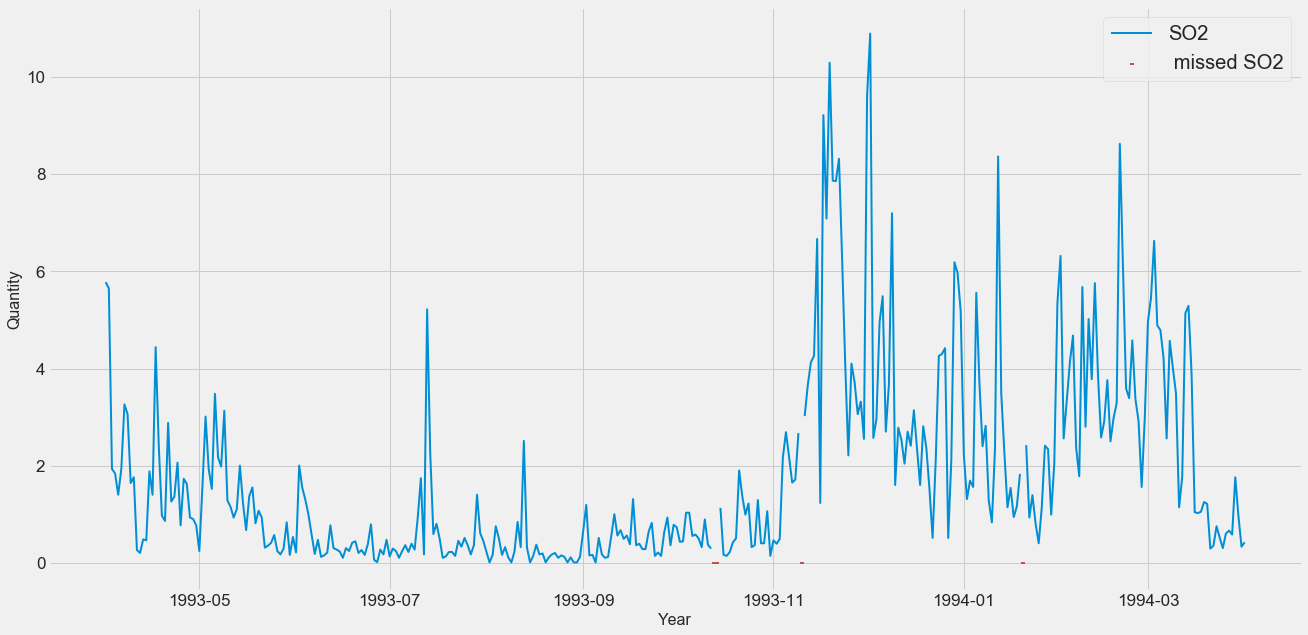

SO4


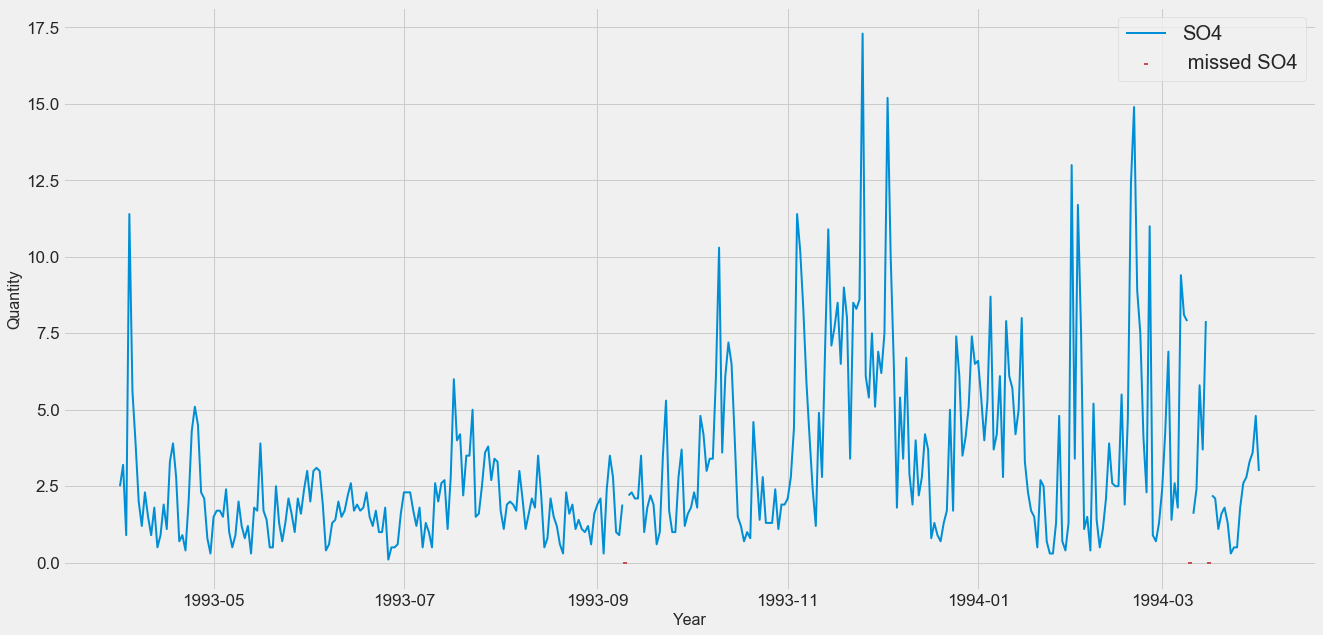

PB


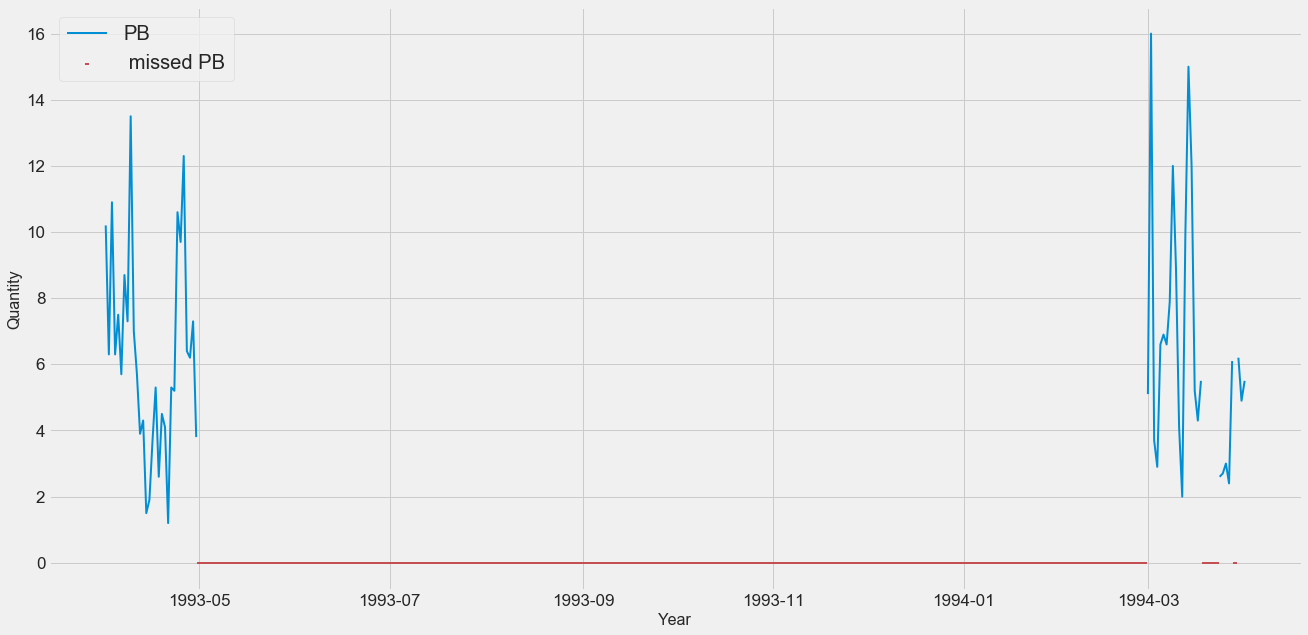

CD


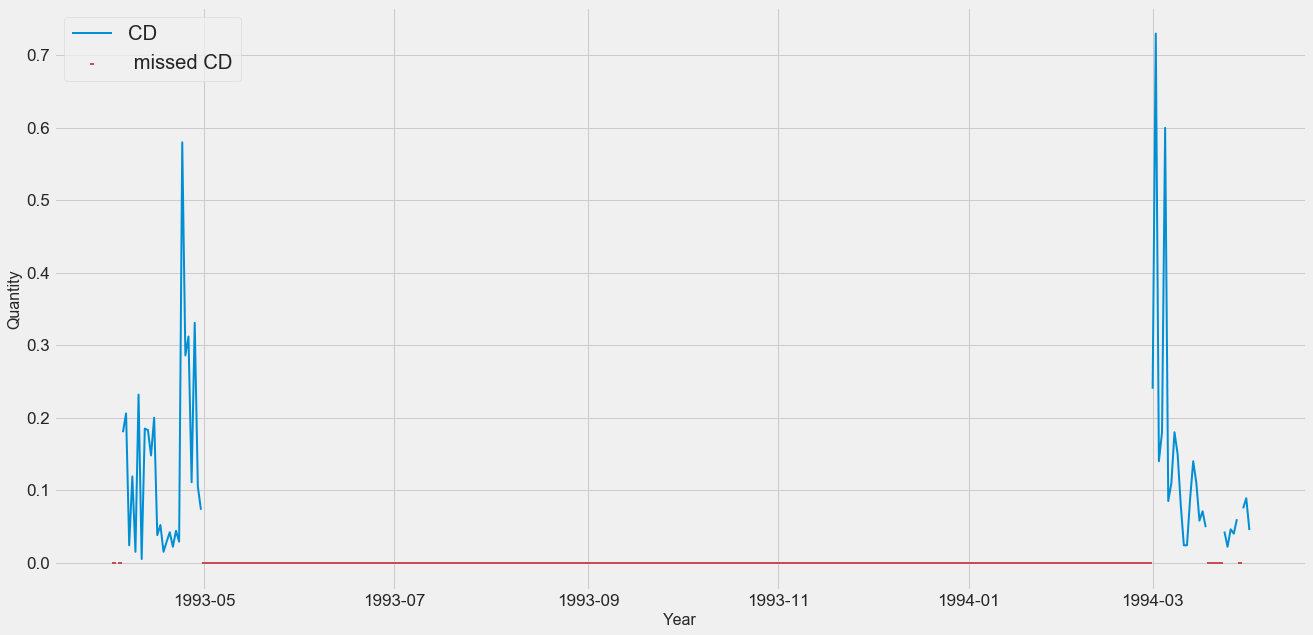

In [96]:
start_date = pd.to_datetime('1987-10-01', format='%Y-%m-%d') #чтобы выравнять начальные значения
end_date = pd.to_datetime('1993-04-01', format='%Y-%m-%d') #чтобы учесть PB, CD

spaces = '\t' * 6
print(f'{spaces}TRAIN')
plot_series(df.drop(columns=['HG', 'NO2'], axis=1), start_date=start_date, end_date=end_date)
#для теста после обученного алгоритма
print('\t\t\t\tTEST')
end_test_date = pd.to_datetime('1994-04-1', format='%Y-%m-%d')
plot_series(df.drop(columns=['HG', 'NO2'], axis=1), start_date=end_date, end_date=end_test_date)

Так как в данных есть "длинные" пропуски, то возьму только те строки, где известны значения, предположение допустимо для дальнейшего анализа

In [97]:
start_ix = list(df.index).index(start_date) if start_date else 0
end_ix = list(df.index).index(end_date) if end_date else -2
df_part = df.drop(columns=['HG', 'NO2', 'SO4'], axis=1).iloc[start_ix: end_ix + 1,:].copy()
print(df_part.shape)
print(df_part.columns)
print(df_part.dropna().shape)
df_part = df_part.dropna().reset_index(drop=True)
df_part.head()

(2002, 4)
Index(['TSP', 'SO2', 'PB', 'CD'], dtype='object')
(1597, 4)


,TSP,SO2,PB,CD
0,9.0,0.02,21.0,0.54
1,5.0,0.03,20.0,0.53
2,14.0,1.60,17.0,0.30
3,35.0,0.14,15.0,0.10
4,35.0,0.13,14.0,0.20


In [98]:
df_part.to_csv(path_to_data / 'prepared_data_prioksk.csv', index=False)

In [101]:
start_ix = list(df.index).index(end_date) if start_date else 0
end_ix = list(df.index).index(end_test_date) if end_date else -2
df_part = df.drop(columns=['HG', 'NO2', 'SO4'], axis=1).iloc[start_ix: end_ix + 1,:].copy()
print(df_part.shape)
print(df_part.columns)
df_part.head()

(366, 4)
Index(['TSP', 'SO2', 'PB', 'CD'], dtype='object')


,TSP,SO2,PB,CD
time,,,,
1993-04-01,21.0,5.78,10.2,0.139
1993-04-02,41.0,5.65,6.3,NaN
1993-04-03,34.0,1.93,10.9,0.034
1993-04-04,64.0,1.84,6.3,NaN
1993-04-05,63.0,1.40,7.5,0.180


In [102]:
df_part.to_csv(path_to_data / 'data_prioksk_test.csv', index=False)